In [ ]:
 pip install gensim konlpy kiwipiepy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import time
from tqdm.notebook import tqdm
import time, pickle, os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from konlpy.tag import Okt
from collections import Counter
from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.cluster import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD

import html

In [ ]:
with open('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster.pkl','rb') as f:
    df = pickle.load(f)

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
def remove_short_tokens(tokens, min_len=2):
    return [t for t in tokens if len(t) >= min_len]

df["article_words"] = df["article_words"].apply(lambda x: remove_short_tokens(x, min_len=2))

In [ ]:
df

,article,re_article,article_words,article_words_str,cluster
1,"허리통증 요통 극복한 10km달리기, 반테린 무릎보호대 안녕하세요?마케팅 옹달샘,마...",허리통증 요통 극복한 km달리기 반테린 무릎보호대 안녕하세요?마케팅 옹달샘 마달샘입...,"[허리, 통증, 요통, 극복, 달리기, 테린, 무릎, 보호대, 마케팅, 옹달샘, 마...",허리 통증 요통 극복 달리기 테린 무릎 보호대 마케팅 옹달샘 마달샘 광복절 날 하루...,1
2,러닝엔 부스터 [ 잠백이 제품 Q&A / 리뷰 게시판 ]\n- 카테고리 미준수 삭제...,러닝엔 부스터 잠백이 제품 Q A 리뷰 게시판 카테고리 미준수 삭제 활동정지 질문글...,"[러닝, 부스터, 잠, 제품, 게시판, 카테고리, 준수, 삭제, 활동, 정지, 질문...",러닝 부스터 잠 제품 게시판 카테고리 준수 삭제 활동 정지 질문 글 등업 후 업로드,0
3,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,"[러닝, 점, 나름, 러닝, 러닝, 고요, 말, 나름, 마일리지, 결과, 지난, 국...",러닝 점 나름 러닝 러닝 고요 말 나름 마일리지 결과 지난 국제 평화 보시 기록 지...,0
4,"7월 3주차 운동일지 - 우중런,작심삼일,짬뽕 이번 3주차에는 비가 많이 왔었습니다...",월 주차 운동일지 우중런 작심삼일 짬뽕 이번 주차에는 비가 많이 왔었습니다월요일 ...,"[주차, 운동, 일지, 우중, 런, 작심삼일, 짬뽕, 주차, 월요일, 문득, 삼일만...",주차 운동 일지 우중 런 작심삼일 짬뽕 주차 월요일 문득 삼일만 무조건 작심삼일 말...,0
5,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요ㅠ,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요,"[러닝, 달, 쉬, 못, 응급실, 컨디션]",러닝 달 쉬 못 응급실 컨디션,0
...,...,...,...,...,...
18750,춘천 마라톤 준비 D-1 매일 달리기 1.266일차!!열정과 도전으로새벽보다 먼저 ...,춘천 마라톤 준비 D 매일 달리기 . 일차!!열정과 도전으로새벽보다 먼저 시작하는 ...,"[준비, 달리기, 일차, 열정, 도전, 먼저, 시작, 승리, 주말, 조깅, 하루, ...",준비 달리기 일차 열정 도전 먼저 시작 승리 주말 조깅 하루 전 기분 최상 충족 감...,0
18751,"남자 10km 마라톤 러닝(달리기) 기록 향상 (1) 바프 끝나고 살이 너무 빨리,...",남자 km 마라톤 러닝 달리기 기록 향상 바프 끝나고 살이 너무 빨리 그리고 많이 ...,"[남자, 러닝, 달리기, 기록, 향상, 바프, 살이, 바프, 당일, 현재, 옷, 무...",남자 러닝 달리기 기록 향상 바프 살이 바프 당일 현재 옷 무게 감안 주 키로 예전...,0
18752,무릎보호대이런거 도움이 될까요?\n왜인지 많이 달리지도 않았는데\n가끔 무릎이 아플...,무릎보호대이런거 도움이 될까요? 왜인지 많이 달리지도 않았는데 가끔 무릎이 아플때가...,"[무릎, 보호대, 도움, 왜인, 무릎, 전혀, 거, 시작]",무릎 보호대 도움 왜인 무릎 전혀 거 시작,0
18753,통영에 뛰기 좋은 러닝코스 아는분 있나요통영 놀러왔는데\n수륙터해안길 말고 더 있을까욥,통영에 뛰기 좋은 러닝코스 아는분 있나요통영 놀러왔는데 수륙터해안길 말고 더 있을까욥,"[러닝, 분, 수륙, 터, 욥]",러닝 분 수륙 터 욥,0


In [ ]:
# @title
#데이터 전체 대상 TF- IDF함수

def TFIDF(df, use_title=False, min_df=3, max_df=0.7, ngram_range=(1,2), top_k=30,
          pos_keep=('NNG','NNP','NR','XR','SL','VV','VA'),   # 유지할 품사
          keep_verbs_as_lemma=True,                          # 동/형용사 '…다'로 원형화
          min_token_len=2,                                   # 한 글자 토큰 제거
          user_stopwords=None):                              # 한국어 불용어 세트(선택)

    #df : 데이터 프레임
    #use_title : title + content
    #min_df : 최소 3개의 글(데이터)에서 등장해야 사용
    #max_df : 전체 데이터에서 차지하는 비중이 70%가 넘어가는 단어 제거
    #ngram_range : 단어 범위 (1 : 혈당, 2 : 혈당 조절)
    #top_k : 상위 단어 범위

    kiwi = Kiwi()
    documents = []
    stop = set(user_stopwords or [])  # 커스텀 불용어 없으면 빈 집합

    # 1) 텍스트 준비
    if use_title:
        text_series = (df['title'].fillna('') + ' ' + df['content'].fillna(''))
    else:
        text_series = df['content'].fillna('')

    text_series = (
        text_series.replace({r'\r|\n': ' '}, regex=True)
                   .str.strip()
    )

    # 2) 형태소 분석 + 품사 필터 + 정규화
    for doc in tqdm(text_series, desc="Tokenizing+POS"):
        toks = []
        for tok in kiwi.tokenize(doc):
            tag = tok.tag   # 예: NNG, NNP, VV, VA ...
            if tag not in pos_keep:
                continue

            # 표면형
            surface = tok.form

            # 동사/형용사 원형화(간단 규칙: 어간 + '다')
            if keep_verbs_as_lemma and tag[0] == 'V':
                lemma = surface + '다'
            else:
                lemma = surface

            # 최소 길이/불용어/숫자만 토큰 제거 등 간단 정제
            if len(lemma) < min_token_len:
                continue
            if lemma in stop:
                continue
            # 숫자만, 기호만 제거 (필요 시 완화/강화)
            if re.fullmatch(r'[\d\W_]+', lemma):
                continue

            toks.append(lemma)

        documents.append(' '.join(toks))

    # 문서가 전부 비면 빈 어휘 에러가 나므로 방어
    if not any(bool(s) for s in documents):
        raise ValueError("형태소 필터링 후 남는 토큰이 없습니다. pos_keep/min_token_len/stopwords를 조정하세요.")

    # 3) TF-IDF 벡터화 (토큰은 이미 공백으로 join된 상태)
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    X = vectorizer.fit_transform(documents)
    terms = vectorizer.get_feature_names_out()

    # 4) 전체 평균 TF-IDF
    mean_scores = np.asarray(X.mean(axis=0)).ravel()

    # 5) Top-k 추출
    top_idx = mean_scores.argsort()[::-1][:top_k]
    global_top = [(terms[i], float(mean_scores[i])) for i in top_idx]

    # 6) DataFrame 반환
    result_df = pd.DataFrame(global_top, columns=['term', 'mean_tfidf'])
    return result_df, vectorizer, X

In [ ]:
'''
# @title
ko_stop = ['러닝','오늘','km','마라톤','안녕하세요','휴레','안녕']

cafe_tfidf_words, cafe_tfidf_vectorizer, cafe_tfidf_x = TFIDF(
    df,
    use_title=False,
    top_k=20,
    user_stopwords=ko_stop,
    pos_keep=('NNG','NNP'),  # 필요 품사만
    keep_verbs_as_lemma=True,                    # 동/형용사 원형화
    min_token_len=2
)
'''

"\n# @title\nko_stop = ['러닝','오늘','km','마라톤','안녕하세요','휴레','안녕']\n\ncafe_tfidf_words, cafe_tfidf_vectorizer, cafe_tfidf_x = TFIDF(\n    df,\n    use_title=False,\n    top_k=20,\n    user_stopwords=ko_stop,\n    pos_keep=('NNG','NNP'),  # 필요 품사만\n    keep_verbs_as_lemma=True,                    # 동/형용사 원형화\n    min_token_len=2\n)\n"

In [ ]:
# @title
#cafe_tfidf_words[:30]

In [ ]:
#특문, 띄어쓰기 제거
def re_pattern(string):
    pattern = re.compile(r'[^a-zA-Z가-힣\s\.\?\!]')
    string = re.sub(pattern, ' ', string)

    pattern2 = re.compile(r'\s+')
    result = re.sub(pattern2, ' ', string)
    return result

In [ ]:
'''
df["article"] = [
    df.at[i, "title"] + df.at[i, "content"]
    for i in df.index
]
df['re_article'] = df['article'].apply(lambda x : re_pattern(x))
'''

'\ndf["article"] = [\n    df.at[i, "title"] + df.at[i, "content"] \n    for i in df.index\n]\ndf[\'re_article\'] = df[\'article\'].apply(lambda x : re_pattern(x))\n'

In [ ]:
stopwords_df = pd.read_csv('/content/drive/My Drive/data/DCX/CX 프로젝트/ko-stopwords.csv')

In [ ]:
stopwords = set(stopwords_df['stopwords'])

In [ ]:
stopwords.update(['오늘', '어제', '아침', '저녁', '새벽', '날씨', '정도', '생각', '느낌', '다시', '처음', '후기','애워', '타파',
                  '정사', '설겆', '꿈별', '휴레', '휴레소', '페메',"송정", "블루라인", "대호수", "남산", "영통", "코스", "마라톤", "하프", "레이스",
                  "꼬우","보거스","후니","홍복","안눙","저금","주섬주섬","수다","꿈별","데디","청티",
                    "생축런","학년","홈페이지","공홈","접수","신청","연맹","후기","리뷰","사진","영상","공지","이벤트",
                  "오늘","어제","내일","새벽","아침","저녁","밤","정도","생각","느낌","다시","처음","이제","사람","모두","여러분","같이","함께",
                  "애워","정사","설겆","액손","파피루스","더피", "춘천","통영","서울","부산","대구","대전","인천","광주","제주",
                   "강원","경남","전남","충북","경기","수도권","한강","한라","지리산", "마라톤코스","올림픽공원","운동장","경기장","공원","하천","강변",
                "날씨","기온","온도","습도","비","눈","비바람","바람","바람부는","맑음","흐림","더위","추위","폭염","한파","미세먼지","황사","습한","건조",
                "봄","여름","가을","겨울","계절","장마","폭우","소나기", "정말","진짜","완전","너무","매우","무척","굉장히","대박","최고","최악",
              "솔직히","그냥","약간","조금","많이","많이들","대부분","보통","평소", "항상","자주","종종","가끔","이번","다음","매번","매일",
    "코스","출발지","결승","완주지점","대회날","행사","이벤트","접수","신청", "기록측정","칩","티셔츠","참가비","기념품","부스","안내","공지","현장"])

In [ ]:
okt = Okt()

ALLOW_TAGS = {'Noun'}

def okt_pos_tagging(s: str, stopwords:set) -> list:
    pos_words = okt.pos(s, stem=True, norm=True)
    return [w for w,t in pos_words if (t in ALLOW_TAGS) and (w not in stopwords)]

In [ ]:
df['re_article'] = df['re_article'].fillna('').astype(str)

tqdm.pandas()
# 토큰화 실행 (진행바 표시)
df['article_words'] = df['re_article'].progress_apply(
    lambda x: okt_pos_tagging(x, stopwords)
)


  0%|          | 0/18755 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


# 2) 필터: 토큰 길이/한글 비율
def ko_ratio(tokens):
    j = "".join(tokens)
    return 0 if not j else sum("가" <= ch <= "힣" for ch in j) / len(j)

mask = (df["article_words"].apply(len) >= 5) & (df["article_words"].apply(ko_ratio) >= 0.4)
df = df[mask].copy()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
#중복제거

keep = pd.Series(False, index=df.index)
if base_mask.sum() > 0:
    vec = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None,
                          min_df=3, max_df=0.9)
    X = vec.fit_transform(df.loc[base_mask, "article_words"].tolist())
    sims = cosine_similarity(X)
    k = np.ones(sims.shape[0], dtype=bool)
    for i in range(sims.shape[0]):
        if not k[i]:
            continue
        dup = np.where((sims[i] > 0.95) & (np.arange(sims.shape[0]) > i))[0]
        k[dup] = False
    keep.loc[df.loc[base_mask].index] = k

df = df[keep].copy()


In [ ]:
df.head()

,article,re_article,article_words
1,"허리통증 요통 극복한 10km달리기, 반테린 무릎보호대 안녕하세요?마케팅 옹달샘,마...",허리통증 요통 극복한 km달리기 반테린 무릎보호대 안녕하세요?마케팅 옹달샘 마달샘입...,"[허리, 통증, 요통, 극복, 달리기, 테린, 무릎, 보호대, 마케팅, 옹달샘, 마..."
2,러닝엔 부스터 [ 잠백이 제품 Q&A / 리뷰 게시판 ]\n- 카테고리 미준수 삭제...,러닝엔 부스터 잠백이 제품 Q A 리뷰 게시판 카테고리 미준수 삭제 활동정지 질문글...,"[러닝, 부스터, 잠, 제품, 게시판, 카테고리, 준수, 삭제, 활동, 정지, 질문..."
3,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,"[러닝, 점, 나름, 러닝, 러닝, 고요, 말, 나름, 마일리지, 결과, 지난, 국..."
4,"7월 3주차 운동일지 - 우중런,작심삼일,짬뽕 이번 3주차에는 비가 많이 왔었습니다...",월 주차 운동일지 우중런 작심삼일 짬뽕 이번 주차에는 비가 많이 왔었습니다월요일 ...,"[주차, 운동, 일지, 우중, 런, 작심삼일, 짬뽕, 주차, 월요일, 문득, 삼일만..."
5,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요ㅠ,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요,"[러닝, 달, 쉬, 못, 응급실, 컨디션]"


In [ ]:
#벡터화

tagged_corpus_list = []

for index, word in enumerate(df['article_words']):
    tag = 'document{}'.format(index) #id
    tagged_corpus_list.append(TaggedDocument(tags=[tag], words = word))

In [ ]:
#doc2vec 모델
model_doc2vec = Doc2Vec(
    vector_size=200,
    window=4,              # 문맥 확장(3→5): 코스/출발/페이스 같은 주변 맥락 반영↑
    min_count=3,           # 희귀어 제거(1→3): 노이즈↓, 일반화↑
    negative=10,           # 네거티브 샘플 수↑: 표현력↑
    hs=0,                  # 네거티브 샘플링 사용
    dm=1,                  # PV-DM(문맥 기반)
    dm_mean=1,             # ★컨텍스트 평균: 문맥 안정화, 유사도에 유리
    epochs=100,             # 학습 반복
    workers=4,             # 코어 수에 맞게
    seed=42
)

In [ ]:
model_doc2vec.build_vocab(tagged_corpus_list)

In [ ]:
model_doc2vec.train(tagged_corpus_list, total_examples=model_doc2vec.corpus_count, epochs=100)

In [ ]:
#데이터 프레임에 추가

vector_list = []

for i in range(len(df)):
    doc2vec = model_doc2vec.dv['document{}'.format(i)]
    vector_list.append(doc2vec)

df['vector'] = vector_list

In [ ]:
#클러스터 수, 실루엣 지수 확인

n_cluster = []
clustering_score = []

for i in tqdm(range(2,10)):
    cluster_model = AgglomerativeClustering(n_clusters=i, linkage='ward')
    cluster_label = cluster_model.fit_predict(list(df['vector']))
    score = silhouette_score(list(df['vector']), cluster_label)

    n_cluster.append(i)
    clustering_score.append(score)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame({'n_cluster':n_cluster, 'clustering_score':clustering_score})

,n_cluster,clustering_score
0,2,0.199391
1,3,0.198528
2,4,0.195050
3,5,0.182397
4,6,0.082130
5,7,0.082803
6,8,0.083392
7,9,0.084003


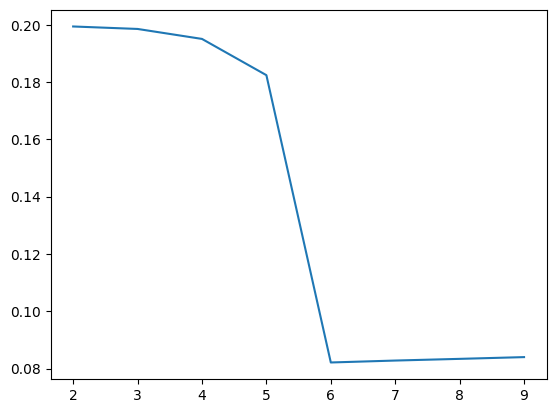

In [ ]:
plt.plot(n_cluster, clustering_score)

In [ ]:
cluster_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_label = cluster_model.fit_predict(list(df['vector']))
cluster_label

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
df['cluster'] = cluster_label
df.head()

,article,re_article,article_words,vector,cluster
1,"허리통증 요통 극복한 10km달리기, 반테린 무릎보호대 안녕하세요?마케팅 옹달샘,마...",허리통증 요통 극복한 km달리기 반테린 무릎보호대 안녕하세요?마케팅 옹달샘 마달샘입...,"[허리, 통증, 요통, 극복, 달리기, 테린, 무릎, 보호대, 마케팅, 옹달샘, 마...","[0.51400524, -1.7318671, 2.5021946, 0.8785937,...",1
2,러닝엔 부스터 [ 잠백이 제품 Q&A / 리뷰 게시판 ]\n- 카테고리 미준수 삭제...,러닝엔 부스터 잠백이 제품 Q A 리뷰 게시판 카테고리 미준수 삭제 활동정지 질문글...,"[러닝, 부스터, 잠, 제품, 게시판, 카테고리, 준수, 삭제, 활동, 정지, 질문...","[0.040878255, 0.30389196, 0.3192045, -0.176085...",0
3,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,"[러닝, 점, 나름, 러닝, 러닝, 고요, 말, 나름, 마일리지, 결과, 지난, 국...","[0.48950654, -1.1864651, 0.9370247, -2.3490803...",0
4,"7월 3주차 운동일지 - 우중런,작심삼일,짬뽕 이번 3주차에는 비가 많이 왔었습니다...",월 주차 운동일지 우중런 작심삼일 짬뽕 이번 주차에는 비가 많이 왔었습니다월요일 ...,"[주차, 운동, 일지, 우중, 런, 작심삼일, 짬뽕, 주차, 월요일, 문득, 삼일만...","[0.28308976, -2.4983275, -0.4927225, 1.6626992...",0
5,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요ㅠ,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요,"[러닝, 달, 쉬, 못, 응급실, 컨디션]","[0.43782464, -0.287148, -0.2754352, -0.0127161...",0


In [ ]:
df['cluster'].value_counts()

,count
cluster,
0,13249
1,2136
4,1283
2,1030
3,167


In [ ]:
df = df.reset_index(drop = True)

In [ ]:
import pickle

with open('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
from scipy.cluster.hierarchy import fcluster

[INFO] 샘플 크기: 17000 / 목표 17000
0    12605
1     2030
2      979
3      167
4     1219
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

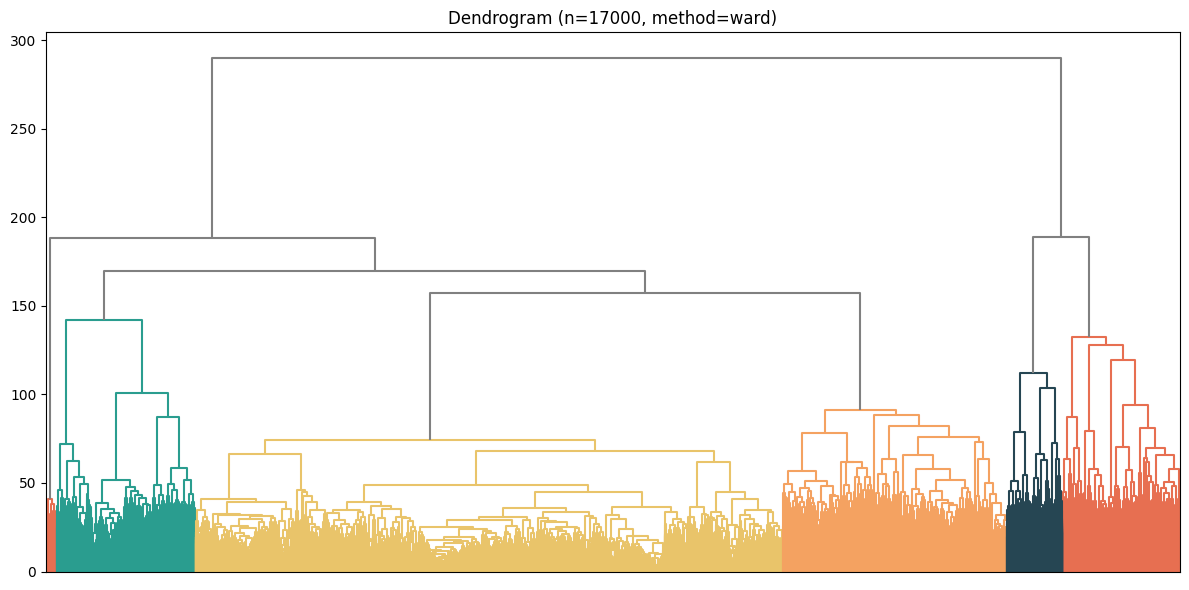

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage, dendrogram , set_link_color_palette

# ==== 설정 ====
N_TARGET = 17000            # 전체 샘플 목표 수
MIN_PER_CLUSTER = 200       # 소수 클러스터 최소 보장 개수 (필요시 조정)
RANDOM_STATE = 42

# ==== 0) 준비: labels / vectors ====
labels = df['cluster'].to_numpy()
# df['vector']가 list/array라면 stack
vectors = np.stack(df['vector'].to_numpy())  # shape: (N_docs, dim)

# ==== 1) 클러스터별 개수 및 비율 ====
cluster_vals, counts = np.unique(labels, return_counts=True)
total = counts.sum()
weights = counts / total

# 1-1) 기본 할당(비례), 최소 보장
base = np.floor(weights * N_TARGET).astype(int)
base = np.maximum(base, np.minimum(counts, MIN_PER_CLUSTER))

# 1-2) 상한: 각 클러스터 보유 수를 초과하지 않도록
base = np.minimum(base, counts)

# 1-3) 정밀 조정: 총합이 N_TARGET이 되도록 오차 분배
allocated = base.copy()
need = N_TARGET - allocated.sum()

# Adjust allocation until the total is N_TARGET
while need != 0:
    if need > 0:
        # Need to add more samples: prioritize clusters with more room
        room = counts - allocated
        order = np.argsort(-room) # Add to clusters furthest from capacity
        for idx in order:
            if need == 0: break
            if allocated[idx] < counts[idx]:
                allocated[idx] += 1
                need -= 1
    else:
        # Need to remove samples: prioritize clusters with most allocated above base
        above_base = allocated - base
        order = np.argsort(-above_base) # Remove from clusters with most allocated above base
        for idx in order:
            if need == 0: break
            if allocated[idx] > base[idx]:
                allocated[idx] -= 1
                need += 1
            elif allocated[idx] > MIN_PER_CLUSTER: # Also allow removal if above min
                 allocated[idx] -= 1
                 need += 1


# ==== 2) 층화 샘pling (클러스터별 allocated만큼) ====
rng = np.random.default_rng(RANDOM_STATE)
take_indices = []

for c, k in zip(cluster_vals, allocated):
    idx_c = np.where(labels == c)[0]
    if k >= len(idx_c):
        take_indices.append(idx_c)  # 전부
    else:
        take_indices.append(rng.choice(idx_c, size=k, replace=False))

take_indices = np.concatenate(take_indices)
take_indices.sort()

X_s = vectors[take_indices]
labels_s = labels[take_indices]

print(f"[INFO] 샘플 크기: {len(take_indices)} / 목표 {N_TARGET}")
print(pd.Series(labels_s).value_counts().sort_index())

# ==== 3) 계층 클러스터링 (ward) ====
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_s)
Z = linkage(X_scaled, method='ward')  # 메모리 빡세면 'average'로 변경

# ==== 4) 덴드로그램 ====
k = 5
h = np.unique(Z[:,2])              # 병합 높이 (유일값)
thr = np.nextafter(h[-k], -np.inf)

plt.figure(figsize=(12, 6))
# 큰 그림만 보고 싶으면 truncate_mode 사용 (p는 가지 수)

h_labels5 = fcluster(Z, t=5, criterion='maxclust')
plt.figure(figsize=(12,6))
dendrogram(
    Z,
    leaf_rotation=90,
    leaf_font_size=9,
    color_threshold=thr,  # 마지막 병합 중 5개 남을 높이에 색 기준 맞추기
    above_threshold_color='grey',
    no_labels=True
)
plt.title(f"Dendrogram (n={X_s.shape[0]}, method=ward)")

plt.tight_layout()
plt.savefig('/content/drive/My Drive/data/DCX/CX 프로젝트/total_dendrogram_sampled.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#TFIDF
all_documents = []
for i in df['cluster'].unique():
    pos_tagged = df[df['cluster'] == i]['article_words']

    document = ''
    for j in pos_tagged:
        doc = " ".join(j) + ' '
        document += doc
    all_documents.append(document)

In [ ]:
#TF-IDF 벡터라이저 선언
vectorizer = TfidfVectorizer(
    min_df=2,                        # 희귀 n-gram 제거(데이터에 따라 3~10 튜닝)
    max_df=1.0,                      # ★너무 흔한 용어 억제
    sublinear_tf=True                # 빈도 증가 완화)

)
# TF-IDF 메트릭스 핏
tfidf_matrix = vectorizer.fit_transform(all_documents)

In [ ]:
feature_name = vectorizer.get_feature_names_out()

In [ ]:
tfidf_value = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(tfidf_value, columns = feature_name)
tfidf_df.index = sorted(df['cluster'].unique())
tfidf_df_T = tfidf_df.T

In [ ]:
for i in tfidf_df_T.columns :
    #점수 정렬
    tfidfvalue = tfidf_df_T[i].sort_values(ascending=False)
    #데이터 프레임으로 변환
    data = {'tfidf_word': tfidfvalue.index, 'tfidf': tfidfvalue.values}
    data_df = pd.DataFrame(data)
    data_df.to_csv(f'/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster{i}_tf_idf.csv', encoding='utf-8-sig')

In [ ]:
import pickle

with open('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
cl0 = pd.read_csv('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster0_tf_idf.csv', encoding='utf-8-sig',index_col = 0)
cl1 = pd.read_csv('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster1_tf_idf.csv', encoding='utf-8-sig',index_col = 0)
cl2 = pd.read_csv('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster2_tf_idf.csv', encoding='utf-8-sig',index_col = 0)
cl3 = pd.read_csv('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster3_tf_idf.csv', encoding='utf-8-sig',index_col = 0)
cl4 = pd.read_csv('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster4_tf_idf.csv', encoding='utf-8-sig',index_col = 0)

In [ ]:
total_tfidf = pd.concat([cl0, cl1, cl2,cl3,cl4], axis=1)[0:30]

In [ ]:
total_tfidf

,tfidf_word,tfidf,tfidf_word,tfidf,tfidf_word,tfidf,tfidf_word,tfidf,tfidf_word,tfidf
0,러닝,0.026023,러닝,0.021116,트레일,0.027456,범퍼,0.066102,러닝,0.032451
1,운동,0.023618,탈퇴,0.020465,대회,0.025416,달리기,0.055478,트레일,0.030735
2,런콥,0.023036,용달차,0.020109,러닝,0.024897,강둑,0.054976,써마핏,0.028129
3,교정,0.023007,신논현역,0.019635,출발,0.023004,가로런,0.051962,벨트,0.027950
4,무릎,0.022979,하울,0.019267,오르막,0.022917,키퍼,0.048342,데카,0.027321
5,통증,0.022971,달리기,0.019212,완주,0.022697,증시,0.047031,트론,0.027306
6,달리기,0.022900,육갑,0.018957,메달,0.022640,아키,0.046421,경량,0.027156
7,자세,0.022554,우중,0.018935,기록,0.022518,러닝,0.045253,운동,0.026937
8,부상,0.022549,청주,0.018931,달리기,0.022507,운동,0.045217,착용,0.026781
9,요법,0.022201,트레일,0.018878,페이스,0.022220,오달완,0.045022,무릎,0.026712


In [ ]:
extra_stopwords = [
    # 지명/장소
    "신논현역","청주","영덕","구래동","울릉도","거제","이촌","갈맷길",
    # 의미 없는 잡음
    "범퍼","강둑","키퍼","증시","아키","립밤","머릿속","복대","사색","자알",
    "포켓","핑키","시어머니","만들기",
    # 브랜드명/제품명
    "써마핏","데카","트론","에볼루티브","달존","노프","노그",
    # 일반적 표현
    "시작","계속","기분","사용","추천","베스트"
]

# 기존 불용어 리스트에 추가
stopwords = list(set(stopwords) | set(extra_stopwords))

df['article_words_str'] = df["article_words"].apply(lambda toks: " ".join(map(str, toks)))

# 다시 벡터화
vec = TfidfVectorizer(
    stop_words=stopwords,          # 반드시 list 여야 함
    min_df=3, max_df=0.9,
    lowercase=False                # 한글 토큰이면 굳이 소문자화 불필요
)

X = vec.fit_transform(df["article_words_str"])


In [ ]:
feature_name = vec.get_feature_names_out()
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_name)
tfidf_df["cluster"] = df["cluster"].values

grouped = tfidf_df.groupby("cluster").mean()  # (클러스터 × 단어)

topk = 30  # 상위 몇 개 뽑을지
cluster_order = sorted(grouped.index)

for c in cluster_order:
    s = grouped.loc[c].sort_values(ascending=False).head(topk)
    out = pd.DataFrame({"tfidf_word": s.index, "tfidf": s.values}).reset_index(drop=True)
    out.to_csv(
        f"/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster{c}_tf_idf.csv",
        index=False, encoding="utf-8-sig"
    )

# --- 2) 저장한 CSV 불러와서 합치기 ---
dfs = []
for c in cluster_order:
    df_c = pd.read_csv(
        f"/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster{c}_tf_idf.csv"
    )
    dfs.append(df_c)

# 옆으로 붙이기
total_tfidf = pd.concat(dfs, axis=1)[:topk]

In [ ]:
total_tfidf

,tfidf_word,tfidf,tfidf_word,tfidf,tfidf_word,tfidf,tfidf_word,tfidf,tfidf_word,tfidf
0,러닝,0.077152,러닝,0.136660,러닝,0.167166,달리기,0.415482,대회,0.115172
1,달리기,0.030290,통증,0.071075,장갑,0.058143,블로그,0.079029,출발,0.056706
2,대회,0.030159,자세,0.069472,착용,0.056241,운동,0.077820,트레일,0.056430
3,운동,0.023207,무릎,0.068971,제품,0.051268,달리,0.073608,러닝,0.051114
4,페이스,0.021475,운동,0.068492,조끼,0.047738,킬로,0.062980,완주,0.049799
5,훈련,0.016437,부상,0.059572,무릎,0.047716,러너,0.062585,기록,0.042643
6,친구,0.016354,달리기,0.055813,트레일,0.039847,운동화,0.061251,페이스,0.041360
7,구해,0.016007,훈련,0.040356,운동,0.039298,아들,0.059957,참가,0.037421
8,기록,0.015891,근육,0.040275,복장,0.036782,무기,0.050079,하프마라톤,0.034251
9,양재동,0.015338,스트레칭,0.030959,보호대,0.032535,주부,0.049974,달리기,0.033612


In [ ]:
df = df[['article','re_article','article_words','article_words_str','cluster']]

In [ ]:
df.head()

,article,re_article,article_words,vector,cluster,article_words_str
1,"허리통증 요통 극복한 10km달리기, 반테린 무릎보호대 안녕하세요?마케팅 옹달샘,마...",허리통증 요통 극복한 km달리기 반테린 무릎보호대 안녕하세요?마케팅 옹달샘 마달샘입...,"[허리, 통증, 요통, 극복, 달리기, 테린, 무릎, 보호대, 마케팅, 옹달샘, 마...","[0.51400524, -1.7318671, 2.5021946, 0.8785937,...",1,허리 통증 요통 극복 달리기 테린 무릎 보호대 마케팅 옹달샘 마달샘 광복절 날 하루...
2,러닝엔 부스터 [ 잠백이 제품 Q&A / 리뷰 게시판 ]\n- 카테고리 미준수 삭제...,러닝엔 부스터 잠백이 제품 Q A 리뷰 게시판 카테고리 미준수 삭제 활동정지 질문글...,"[러닝, 부스터, 잠, 제품, 게시판, 카테고리, 준수, 삭제, 활동, 정지, 질문...","[0.040878255, 0.30389196, 0.3192045, -0.176085...",0,러닝 부스터 잠 제품 게시판 카테고리 준수 삭제 활동 정지 질문 글 등업 후 업로드
3,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,이번 여름 러닝하면서 후회되는 점올 여름엔 나름 꾸준히 러닝을 했습니다. 거의 매일...,"[러닝, 점, 나름, 러닝, 러닝, 고요, 말, 나름, 마일리지, 결과, 지난, 국...","[0.48950654, -1.1864651, 0.9370247, -2.3490803...",0,러닝 점 나름 러닝 러닝 고요 말 나름 마일리지 결과 지난 국제 평화 보시 기록 지...
4,"7월 3주차 운동일지 - 우중런,작심삼일,짬뽕 이번 3주차에는 비가 많이 왔었습니다...",월 주차 운동일지 우중런 작심삼일 짬뽕 이번 주차에는 비가 많이 왔었습니다월요일 ...,"[주차, 운동, 일지, 우중, 런, 작심삼일, 짬뽕, 주차, 월요일, 문득, 삼일만...","[0.28308976, -2.4983275, -0.4927225, 1.6626992...",0,주차 운동 일지 우중 런 작심삼일 짬뽕 주차 월요일 문득 삼일만 무조건 작심삼일 말...
5,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요ㅠ,러닝 한달 쉬니까 못 뛰겠어요..응급실 갔다와서 컨디션이 올라오질 않네요,"[러닝, 달, 쉬, 못, 응급실, 컨디션]","[0.43782464, -0.287148, -0.2754352, -0.0127161...",0,러닝 달 쉬 못 응급실 컨디션


In [ ]:
import pickle

with open('/content/drive/My Drive/data/DCX/CX 프로젝트/total_cluster.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
total_tfidf.to_csv('/content/drive/My Drive/data/DCX/CX 프로젝트/total_tfidf.csv',encoding = 'utf-8-sig')

**🟢 클러스터 0 : 일반 러너 (훈련·기록 지향)**

주요 키워드: 러닝, 달리기, 운동, 페이스, 훈련, 기록, 완주, 목표, 도전

특징: 기본적인 러닝 활동과 성취 지향 — 훈련·페이스 관리·완주 경험을 중시하는 일반 러너

**🟡 클러스터 1 : 부상 관리형 러너**

주요 키워드: 통증, 자세, 무릎, 부상, 근육, 스트레칭, 착지, 예방, 회복, 치료, 교정

특징: 부상 방지·재활에 초점을 맞추는 그룹 — 전문적인 훈련법·피지컬 관리 관심이 높음

**🔵 클러스터 2 : 장비 사용자 / 소비자 (리뷰어)**

주요 키워드: 장갑, 착용, 제품, 조끼, 보호대, 사이즈, 기능, 나이키, 양말, 모자, 경량, 마스크, 용품

특징: 러닝 용품 및 장비 중심 — 장비 선택, 브랜드, 착용감 후기를 중시하는 소비자형 러너

**🟣 클러스터 3 : 커뮤니티·일상형 러너 (스토리 공유)**

주요 키워드: 블로그, 주부, 아들, 우울증, 언니, 허리, 극복, 자신감, 결심, 행복

특징: 개인 서사·생활 맥락과 함께 러닝을 이야기 — 동기부여·감정 교류 중심의 커뮤니티형

**🔴 클러스터 4 : 대회 참가자 / 레이서**

주요 키워드: 대회, 출발, 완주, 기록, 페이스, 참가, 하프마라톤, 준비, 도착, 메달

특징: 대회 경험 중심 — 기록 단축, 레이스 전략, 완주 성취를 강조하는 경쟁/참가자